In [1]:
# Mapping of region codes to their brancher first letter.
region_branch_ignore = {
    'AMD': 'A',
    'BLR': 'B',
    'CHE': 'C',
    'CJB': 'E',
    'HYD': 'H',
    'IDR': 'I',
    'HHPT': 'J',
    'CCU': 'K',
    'MUM': 'M',
    'DDL': 'N',
    'COK': 'O',
    'PNQ': 'P',
    'JAI': 'Q',
    'NGP': 'R',
    'PAT': 'T',
    'UPT': 'U',
    'VJA': 'V',
    'BBI': 'W',
    'GAU': 'X'
}

In [2]:
import pandas as pd

# ==========================
# Step 1: Read CSV (skip empty first row)
# ==========================
raw = pd.read_csv("data.csv", header=None, skiprows=1)

# ==========================
# Step 2: Extract metadata
# ==========================
types = raw.iloc[0, 7:].astype(str).str.strip().tolist()          # type row
branch_codes = raw.iloc[4, 7:].astype(str).str.strip().tolist()   # branch row
service_types = raw.iloc[6:, 5].astype(str).str.strip().tolist()  # Service_Type column
org_regions = raw.iloc[6:, 1].astype(str).str.strip().tolist()    # region column

# Numeric data
data_values = raw.iloc[6:, 7:].apply(pd.to_numeric, errors='coerce').fillna(0)

# ==========================
# Step 3: Build long-format DataFrame, ignoring branches whose first letter matches region's ignore letter
# ==========================
rows = []
for i, (region, service_type) in enumerate(zip(org_regions, service_types)):
    ignore_letter = region_branch_ignore.get(region, None)
    for j, (branch, type_) in enumerate(zip(branch_codes, types)):
        if ignore_letter is not None and branch and branch[0] == ignore_letter:
            value = 0
        else:
            value = data_values.iat[i, j]
        rows.append({
            "Region": region,
            "Service_Type": service_type,
            "Type": type_,
            "Branch": branch,
            "Value": value
        })

df_long = pd.DataFrame(rows)

# ==========================
# Step 4a: Build one combined CSV (absolute values)
# ==========================
df_pivot = df_long.pivot_table(
    index=["Region", "Type", "Service_Type"],
    columns="Branch",
    values="Value",
    aggfunc='sum'
).reset_index()

# Add Total column
df_pivot["Total"] = df_pivot.iloc[:, 3:].sum(axis=1)

# Fill NaN with 0
df_pivot.fillna(0, inplace=True)

# Save absolute values CSV
df_pivot.to_csv("all_data.csv", index=False)
print("Saved: all_data.csv")

# ==========================
# Step 4b: Build percentage CSV
# ==========================
df_percent = df_pivot.copy()

# Convert branch values into percentages of Total
branch_cols = df_percent.columns[3:-1]  # all branch columns
df_percent[branch_cols] = df_percent[branch_cols].div(df_percent["Total"], axis=0) * 100

# Drop Total column for percentage CSV
df_percent = df_percent.drop(columns=["Total"])

# Fill NaN with 0 (in case Total = 0)
df_percent.fillna(0, inplace=True)

# Save percentage CSV
df_percent.to_csv("all_data_percentage.csv", index=False)
print("Saved: all_data_percentage.csv")

/var/folders/lw/mxt4vf712k5_lslhrjcqqj700000gn/T/ipykernel_78361/242742510.py:6: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,

Saved: all_data.csv
Saved: all_data_percentage.csv


In [3]:
import pandas as pd

# Read the absolute and percentage CSVs
df_abs = pd.read_csv("all_data.csv")
df_pct = pd.read_csv("all_data_percentage.csv")

# Melt both (wide → long)
df_abs_long = df_abs.melt(
    id_vars=["Region", "Type", "Service_Type", "Total"],
    var_name="Branch",
    value_name="Value"
)

df_pct_long = df_pct.melt(
    id_vars=["Region", "Type", "Service_Type"],
    var_name="Branch",
    value_name="Percentage"
)

# Merge absolute values with percentages
df_merge = pd.merge(
    df_abs_long,
    df_pct_long,
    on=["Region", "Type", "Service_Type", "Branch"],
    how="inner"
)

# Define thresholds
thresholds = {"Volume": 15, "Billed Wt": 20}

# Collect results
results = []
for (region, stype, type_), group in df_merge.groupby(["Region", "Service_Type", "Type"]):
    thresh = thresholds.get(type_, 0)

    # Filter using absolute values
    filtered = group[group["Value"] >= thresh]

    # Count branches
    num_branches = len(filtered)

    # Cumulative percentage (raw sum)
    cum_pct = filtered["Percentage"].sum()

    # Branch list
    branch_list = filtered["Branch"].tolist()

    results.append({
        "Region": region,
        "Service_Type": stype,
        "Type": type_,
        "Num_Branches": num_branches,
        "Cumulative_Percentage": cum_pct,
        "Branches": ", ".join(branch_list) if branch_list else ""
    })

# Build summary DataFrame
df_summary = pd.DataFrame(results)

# Save as bag_summary
df_summary.to_csv("bag_summary.csv", index=False)
print("Saved: bag_summary.csv")

Saved: bag_summary.csv


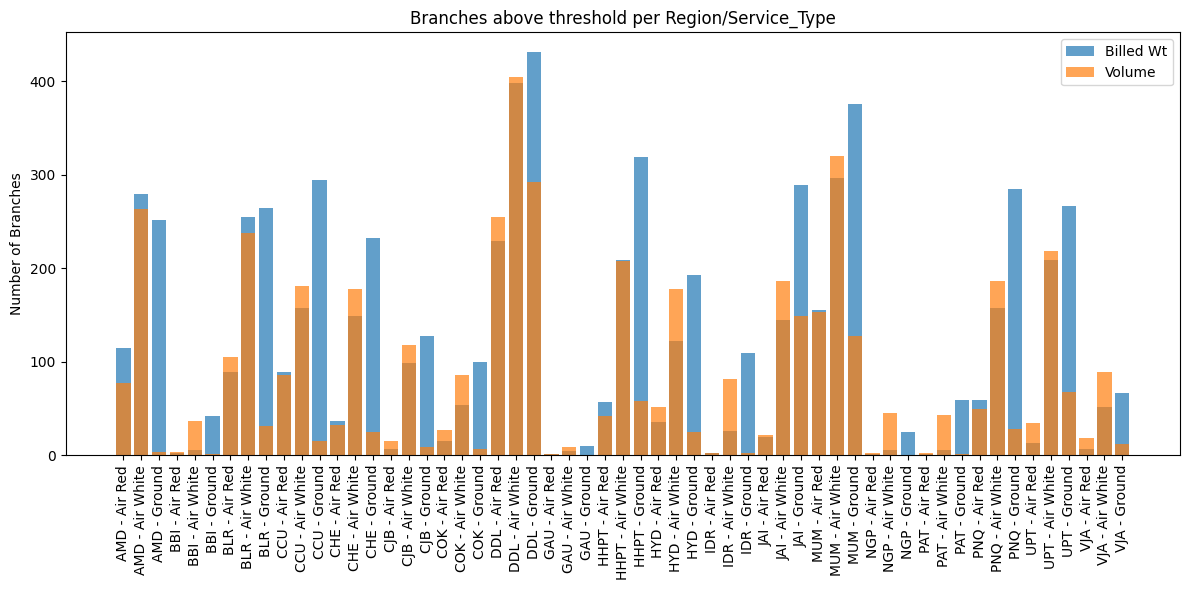

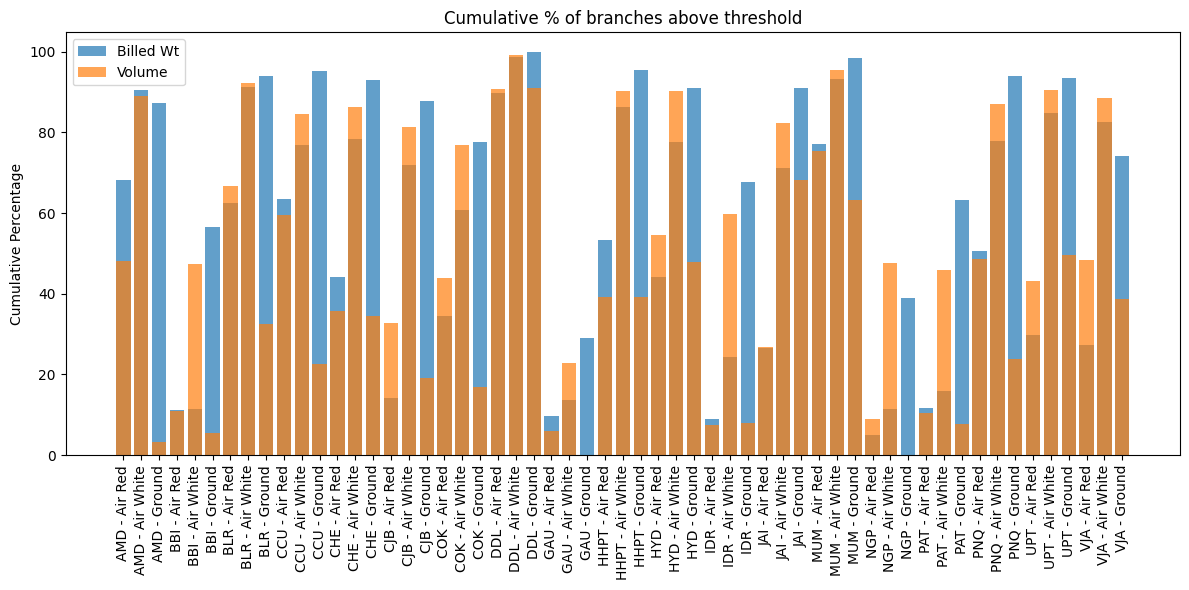

In [4]:
import matplotlib.pyplot as plt

# Load summary
df_summary = pd.read_csv("bag_summary.csv")

# --- 1. Branch count per region/type ---
plt.figure(figsize=(12,6))
for t in df_summary["Type"].unique():
    subset = df_summary[df_summary["Type"] == t]
    plt.bar(subset["Region"] + " - " + subset["Service_Type"], 
            subset["Num_Branches"], label=t, alpha=0.7)

plt.xticks(rotation=90)
plt.ylabel("Number of Branches")
plt.title("Branches above threshold per Region/Service_Type")
plt.legend()
plt.tight_layout()
plt.show()


# --- 2. Cumulative percentage per region/type ---
plt.figure(figsize=(12,6))
for t in df_summary["Type"].unique():
    subset = df_summary[df_summary["Type"] == t]
    plt.bar(subset["Region"] + " - " + subset["Service_Type"], 
            subset["Cumulative_Percentage"], label=t, alpha=0.7)

plt.xticks(rotation=90)
plt.ylabel("Cumulative Percentage")
plt.title("Cumulative % of branches above threshold")
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load bag_summary
df_summary = pd.read_csv("bag_summary.csv")

# Make sure output folder exists
os.makedirs("elbow_plots", exist_ok=True)

def find_elbow(x, y):
    """Find elbow (knee) using max perpendicular distance from line connecting first and last points."""
    p1, p2 = np.array([x[0], y[0]]), np.array([x[-1], y[-1]])
    line_vec = p2 - p1
    line_vec = line_vec / np.linalg.norm(line_vec)

    distances = []
    for i in range(len(x)):
        p = np.array([x[i], y[i]])
        proj_len = np.dot(p - p1, line_vec)
        proj_point = p1 + proj_len * line_vec
        dist = np.linalg.norm(p - proj_point)
        distances.append(dist)

    elbow_idx = int(np.argmax(distances))
    return elbow_idx

def analyze_group(branches_str, region, stype, type_):
    if not isinstance(branches_str, str) or branches_str.strip() == "":
        return None
    
    branches = [b.strip() for b in branches_str.split(",")]
    
    # Recover percentages
    subset = df_pct_long[
        (df_pct_long["Region"] == region) &
        (df_pct_long["Service_Type"] == stype) &
        (df_pct_long["Type"] == type_) &
        (df_pct_long["Branch"].isin(branches))
    ].copy()

    if subset.empty:
        return None

    subset = subset.sort_values("Percentage", ascending=False).reset_index(drop=True)
    subset["Cumulative_Percentage"] = subset["Percentage"].cumsum()

    # Elbow
    x = np.arange(1, len(subset) + 1)
    y = subset["Cumulative_Percentage"].values
    elbow_idx = find_elbow(x, y)

    opt_num_branches = x[elbow_idx]
    opt_cum_pct = y[elbow_idx]
    opt_branches = subset.loc[:elbow_idx, "Branch"].tolist()

    # --- Plot ---
    plt.figure(figsize=(8,5))
    plt.plot(x, y, marker="o", label="Cumulative %")
    plt.axvline(opt_num_branches, color="r", linestyle="--")
    plt.axhline(opt_cum_pct, color="r", linestyle="--")
    plt.scatter(opt_num_branches, opt_cum_pct, color="red", zorder=5, label="Elbow Point")

    plt.text(opt_num_branches, opt_cum_pct, 
             f"Opt = {opt_num_branches} branches\nCum% = {opt_cum_pct:.2f}",
             fontsize=9, ha="left", va="bottom", color="red")

    plt.title(f"Elbow Plot - {region}, {stype}, {type_}")
    plt.xlabel("Number of Branches")
    plt.ylabel("Cumulative Percentage")
    plt.legend()
    plt.tight_layout()

    # Save plot
    fname = f"elbow_plots/{region}_{stype}_{type_}.png".replace(" ", "_")
    plt.savefig(fname, dpi=150)
    plt.close()

    return {
        "Region": region,
        "Service_Type": stype,
        "Type": type_,
        "Optimal_Num_Branches": opt_num_branches,
        "Optimal_Cumulative_Percentage": opt_cum_pct,
        "Branches": ", ".join(opt_branches)
    }

# Collect results
optimal_results = []
for _, row in df_summary.iterrows():
    result = analyze_group(row["Branches"], row["Region"], row["Service_Type"], row["Type"])
    if result:
        optimal_results.append(result)

# Save summary
df_optimal = pd.DataFrame(optimal_results)
df_optimal.to_csv("optimal_branches.csv", index=False)
print("Saved: optimal_branches.csv")
print("Plots saved in folder: elbow_plots/")

/var/folders/lw/mxt4vf712k5_lslhrjcqqj700000gn/T/ipykernel_78361/232658319.py:16: RuntimeWarning: invalid value encountered in divide
  line_vec = line_vec / np.linalg.norm(line_vec)
/var/folders/lw/mxt4vf712k5_lslhrjcqqj700000gn/T/ipykernel_78361/232658319.py:16: RuntimeWarning: invalid value encountered in divide
  line_vec = line_vec / np.linalg.norm(line_vec)
/var/folders/lw/mxt4vf712k5_lslhrjcqqj700000gn/T/ipykernel_78361/232658319.py:16: RuntimeWarning: invalid value encountered in divide
  line_vec = line_vec / np.linalg.norm(line_vec)
/var/folders/lw/mxt4vf712k5_lslhrjcqqj700000gn/T/ipykernel_78361/232658319.py:16: RuntimeWarning: invalid value encountered in divide
  line_vec = line_vec / np.linalg.norm(line_vec)
/var/folders/lw/mxt4vf712k5_lslhrjcqqj700000gn/T/ipykernel_78361/232658319.py:16: RuntimeWarning: invalid value encountered in divide
  line_vec = line_vec / np.linalg.norm(line_vec)
/var/folders/lw/mxt4vf712k5_lslhrjcqqj700000gn/T/ipykernel_78361/232658319.py:16: Run

Saved: optimal_branches.csv
Plots saved in folder: elbow_plots/


In [6]:
import json
import pandas as pd

# Load your mapping JSON
with open("des_mappings.json", "r") as f:
    mapping = json.load(f)

# Flatten the nested structure
rows = []
for zone, regions in mapping.items():
    for region, cities in regions.items():
        for city, branches in cities.items():
            for branch_code, branch_name in branches.items():
                rows.append({
                    "Zone": zone,
                    "Region": region,
                    "City": city,
                    "BranchCode": branch_code,
                    "BranchName": branch_name
                })

df_mapping = pd.DataFrame(rows)

# Count branches per Region
df_region_counts = df_mapping.groupby("Region").size().reset_index(name="Self_Branches")

# Load optimal branches
df_optimal = pd.read_csv("optimal_branches.csv")

# 1. Sum of optimal branches per Region×Type
df_sum_opt = df_optimal.groupby(["Region", "Type"])["Optimal_Num_Branches"].sum().reset_index()
df_sum_opt = df_sum_opt.rename(columns={"Optimal_Num_Branches": "Sorting_Locations_for_Optimal_Branches"})

# 2. Merge with region branch counts
df_fd = pd.merge(df_sum_opt, df_region_counts, on="Region", how="left")

# 3. Sorting location needed
df_fd["Sorting_Location_Needed"] = (
    df_fd["Sorting_Locations_for_Optimal_Branches"] + 60 + 2 * df_fd["Self_Branches"]
)

# Save final
df_fd.to_csv("final_sorting_location.csv", index=False)
print("Saved: final_sorting_location.csv")

Saved: final_sorting_location.csv
